In [1]:
##load in libraries

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import seaborn as sns
import itertools
import torch.nn as nn
from torchvision import transforms, io
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances as pdist
from sklearn.metrics.pairwise import cosine_distances
from scipy.stats import entropy
from tqdm import tqdm
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.image as mpimg
import ast
from scipy.spatial.distance import jensenshannon as jsd
from sklearn.metrics import auc
import statsmodels.formula.api as smf
from scipy.stats import rankdata
pd.options.mode.chained_assignment = None

from scipy.stats import spearmanr, pearsonr
import warnings
import random
# Ignore all warnings
warnings.filterwarnings("ignore")


/Users/kushinm/miniforge3/envs/sketch_models/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/kushinm/miniforge3/envs/sketch_models/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Library not loaded: '@rpath/libjpeg.8.dylib'
  Referenced from: '/Users/kushinm/miniforge3/envs/sketch_models/lib/python3.8/site-packages/torchvision/image.so'
  Reason: tried: '/Users/kushinm/miniforge3/envs/sketch_models/lib/python3.8/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/Users/kushinm/miniforge3/envs/sketch_models/lib/python3.8/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/Users/kushinm/miniforge3/envs/sketch_models/lib/python3.8/lib-dynload/../../libjpeg.8.dylib' (no such file), '/Users/kushinm/miniforge3/envs/sketch_models/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Fa

In [2]:
### set font properties for plots
sns.set(font='Helvetica')
sns.set_style('white')
sns.set_context('paper')
lfont = {'fontname':'Helvetica'}
mpl.rcParams['pdf.fonttype'] = 42

## Helper functions

In [3]:
def compute_human_snp(this_sample_recog_df):
    concepts=[]
    ranks = []
    cum_props=[]
    abstraction =[]

    for this_concept in human_response_vec_df.uniqueID.unique(): ## to maintain same order as response vec df
        for this_abstraction in human_response_vec_df.abstraction.unique():

            ds= this_sample_recog_df[(this_sample_recog_df['uniqueID']==this_concept) & (this_sample_recog_df['abstraction']==this_abstraction)]
            ds = ds[ds.top1_rank!=0]
            ranks.append(ds['top1_rank'].value_counts(normalize=True).sort_index().cumsum().index)
            cum_props.append(ds['top1_rank'].value_counts(normalize=True).sort_index().cumsum().values)
            concepts.append([this_concept]*ds['top1_rank'].value_counts(normalize=True).sort_index().cumsum().index.shape[0])
            abstraction.append([this_abstraction]*ds['top1_rank'].value_counts(normalize=True).sort_index().cumsum().index.shape[0])

    ranks = np.concatenate(ranks)
    cum_props = np.concatenate(cum_props)
    concepts = np.concatenate(concepts)
    abstraction = np.concatenate(abstraction)

    this_cum_prop_df = pd.DataFrame({'concept':concepts,'rank':ranks,'cum_prop':cum_props,'abstraction':abstraction})

    this_cum_prop_df['rank'] = this_cum_prop_df['rank']/1854



    this_auc_df = pd.DataFrame(columns = ['concept','auc'])
    for this_concept in this_cum_prop_df.concept.unique():
        for this_abstraction in this_cum_prop_df.abstraction.unique():
            this_df = this_cum_prop_df[(this_cum_prop_df['concept']==this_concept) & (this_cum_prop_df['abstraction']==this_abstraction)]
            this_df = pd.concat([this_df,pd.DataFrame({'concept':this_concept,'rank':1,'cum_prop':1,'abstraction':this_abstraction},index=[0])])
            # return this_df
            # this_auc= this_df.groupby('concept').apply(lambda x: auc(x['rank'],x['cum_prop']))
            this_auc = auc(this_df['rank'],this_df['cum_prop'])
            this_auc_df = pd.concat([this_auc_df,pd.DataFrame({'concept':this_concept,'auc':this_auc,'abstraction':this_abstraction},index=[0])])
    return this_auc_df


def compute_snp_EV(this_sample_df, this_sample_recog_df,this_model,this_auc_df):

    concepts=[]
    ranks = []
    cum_props=[]
    models=[]
    abstraction =[]

    for concept in this_sample_df.uniqueID.unique():

        for this_abstraction in this_sample_df.abstraction.unique():
            ds= this_sample_df[(this_sample_df['uniqueID']==concept) &(this_sample_df['abstraction']==this_abstraction)]
            ds = ds[ds[f'top1_rank_{this_model}_late']!=0]
            ranks.append(ds[f'top1_rank_{this_model}_late'].value_counts(normalize=True).sort_index().cumsum().index)
            cum_props.append(ds[f'top1_rank_{this_model}_late'].value_counts(normalize=True).sort_index().cumsum().values)
            concepts.append([concept]*ds[f'top1_rank_{this_model}_late'].value_counts(normalize=True).sort_index().cumsum().index.shape[0])
            models.append([this_model]*ds[f'top1_rank_{this_model}_late'].value_counts(normalize=True).sort_index().cumsum().index.shape[0])
            abstraction.append([this_abstraction]*ds[f'top1_rank_{this_model}_late'].value_counts(normalize=True).sort_index().cumsum().index.shape[0])

    ranks = np.concatenate(ranks)
    cum_props = np.concatenate(cum_props)
    concepts = np.concatenate(concepts)
    models = np.concatenate(models)
    abstraction = np.concatenate(abstraction)

    model_cum_prop_df = pd.DataFrame({'concept':concepts,'rank':ranks,'cum_prop':cum_props,'model':models,'abstraction':abstraction})

    model_cum_prop_df['rank'] = model_cum_prop_df['rank']/1854

    model_auc_df = pd.DataFrame(columns = ['concept','auc','abstraction','model'])

    this_cum_prop_df = model_cum_prop_df[model_cum_prop_df['model']==this_model]

    for this_concept in this_cum_prop_df.concept.unique():
        for this_abstraction in cum_prop_df.abstraction.unique():
            this_df = this_cum_prop_df[(this_cum_prop_df['concept']==this_concept) & (this_cum_prop_df['abstraction']==this_abstraction)]
            this_df = pd.concat([this_df,pd.DataFrame({'concept':this_concept,'rank':1,'cum_prop':1, 'model':this_model,'abstraction':this_abstraction},index=[0])])
            if this_df.shape[0]==1:
                this_df = pd.concat([this_df,pd.DataFrame({'concept':this_concept,'rank':0,'cum_prop':1, 'model':this_model,'abstraction':this_abstraction},index=[0])])    
            this_auc= this_df.groupby('concept').apply(lambda x: auc(x['rank'],x['cum_prop']))
            model_auc_df = pd.concat([model_auc_df,pd.DataFrame({'concept':this_concept,'auc':this_auc,'abstraction':this_abstraction,'model':this_model})])

    Y = this_auc_df['auc'].values
    X = np.column_stack([model_auc_df['auc'].values,model_auc_df['abstraction'].values,model_auc_df['auc'].values*model_auc_df['abstraction'].values])
    X = sm.add_constant(X)
    m_snp = sm.OLS(Y,X).fit()

    return m_snp.rsquared_adj



In [4]:
##tmo

## Data preparation

Load in data csvs and preprocess them for analyses.

In [5]:
## set up directory structures

proj_dir = os.path.abspath('../')
data_dir = os.path.join(proj_dir, 'data')

analysis_dir = os.path.join(proj_dir, 'analysis')
results_dir = os.path.join(proj_dir, 'results')
csv_dir = os.path.join(results_dir, 'csv')
plot_dir = os.path.join(results_dir, 'plots')


In [9]:
tmp

,sketch_id,concept,filename,uniqueID,strokes,undo_history,abstraction,num_strokes,participant_subjectiveSkill,participant_subjectiveImagery,participant_effort
0,63ce038a8988816856b67abd,beachball,beachball_18s.jpg,beachball,"[[{'x': 161, 'y': 133, 'color': '#000000', 'ac...",[],4000,4,3,5,5
1,63ce03918988816856b67abe,bathrobe,bathrobe_11s.jpg,bathrobe,"[[{'x': 118, 'y': 68, 'color': '#000000', 'act...",[],4000,1,3,5,5
2,63ce03988988816856b67ac1,taillight,taillight_01b.jpg,taillight,"[[{'x': 207, 'y': 170, 'color': '#000000', 'ac...",[],4000,1,3,5,5
3,63ce039f8988816856b67ac2,knob,knob_01b.jpg,knob,"[[{'x': 201, 'y': 188, 'color': '#000000', 'ac...",[],4000,2,3,5,5
4,63ce03a08988816856b67ac3,beanie,beanie_11s.jpg,beanie,[],[],4000,0,1,4,5
...,...,...,...,...,...,...,...,...,...,...,...
95629,63d0017d2c65c64f1f7f98ae,button,button1_08s.jpg,button1,"[[{'x': 274, 'y': 204, 'color': '#000000', 'ac...",[],16000,5,2,7,5
95630,63d001912c65c64f1f7f98af,bench,bench_16n.jpg,bench,"[[{'x': 277, 'y': 71, 'color': '#000000', 'act...",[],16000,14,2,7,5
95631,63d001a42c65c64f1f7f98b0,quesadilla,quesadilla_22s.jpg,quesadilla,"[[{'x': 228, 'y': 78, 'color': '#000000', 'act...",[],16000,10,2,7,5
95632,63d001b62c65c64f1f7f98b1,guitar,guitar_04s.jpg,guitar,"[[{'x': 195, 'y': 40, 'color': '#000000', 'act...",[],16000,15,2,7,5


In [8]:
tmp = pd.read_csv(os.path.join(data_dir,'neurips_DB_human_clean.csv'))


# csv_file_path = os.path.join(data_dir,'neurips_DB_human.csv')

# # Define the chunk size (number of rows to read at a time)
# chunk_size = 1000  # Adjust the chunk size as needed

# # Initialize an empty list to hold the individual DataFrames
# all_dataframes = []

# # Iterate through the CSV file in chunks
# for chunk in pd.read_csv(csv_file_path, chunksize=chunk_size):
#     # Append each chunk to the list
#     all_dataframes.append(chunk)

# # Concatenate all the DataFrames into one big DataFrame
# tmp = pd.concat(all_dataframes, ignore_index=True)

In [7]:
tmp['abstraction'].unique()

array(['4000', nan, " 'y': 206", " {'x': 339", " {'x': 370", " {'x': 180",
       " 'y': 335", " {'x': 187", " {'x': 338", '32000', " {'x': 302",
       " {'x': 202", " {'x': 297", " 'y': 221", " 'y': 147", " {'x': 225",
       " 'action': 'move'}", " {'x': 351", " {'x': 316",
       " {'action': 'end'", " 'y': 253", " 'y': 291", " {'x': 427",
       " {'x': 394", " {'x': 134", " {'x': 240", " 'y': 216",
       " {'x': 300", " {'x': 121", " {'x': 107", " 'y': 313",
       " {'x': 234", " {'x': 214", " {'x': 257", " 'y': 365", " 'y': 412",
       " {'x': 262", " 'y': 366", " {'x': 392", " {'x': 211",
       " {'x': 352", " 'y': 89", " {'x': 157", " {'x': 457", " {'x': 416",
       " {'x': 364", " 'y': 159", " {'x': 188", " 'y': 303", " {'x': 177",
       " {'x': 153", " 'y': 257", " {'x': 308", " {'x': 249", " 'y': 230",
       " {'x': 423", " 'color': '#000000'", " {'x': 96", " {'x': 78",
       " {'x': 289", " {'x': 327", " 'y': 376", " 'y': 355", " 'y': 295",
       " 'y': 308", " 'y

In [17]:
tmp.columns

Index(['sketch_id', 'concept', 'filename', 'uniqueID', 'strokes',
       'undo_history', 'abstraction', 'num_strokes',
       'participant_subjectiveSkill', 'participant_subjectiveImagery',
       'participant_effort'],
      dtype='object')

In [14]:
# tmp0.to_csv(os.path.join(data_dir,'neurips_DB_human_pretty.csv'),index=False)

In [11]:
human_recog_df

NameError: name 'human_recog_df' is not defined

In [13]:
things_main_df = pd.read_csv(os.path.join(data_dir, 'things_concepts.tsv'), sep='\t') ### main CSV of THINGS concept metadata
human_recog_df = pd.read_csv(os.path.join(data_dir, 'human_recog_df.csv')) ### raw recognition experiment data on human sketches
machine_recog_df = pd.read_csv(os.path.join(data_dir, 'machine_recog_df.csv')) ### raw recognition experiment data on machine sketches

things1854concepts = things_main_df.uniqueID.values ## get a list of all the unique THINGS concept labels
concept2category_dict = dict(zip(things_main_df.uniqueID, things_main_df['All Bottom-up Categories'])) ## create a dictionary of concepts to bottom-up categories


spose_embeds = pd.read_csv(os.path.join(data_dir,'THINGS_spose.txt'), sep='\t', header=None) ### semantic embeddings for things concepts based on human similarity ratings
spose_cols = spose_embeds.columns.tolist()
spose_embeds['concept']=things1854concepts

FileNotFoundError: [Errno 2] No such file or directory: '/Users/kushinm/Documents/Github/neurips-db-seva/data/human_recog_df.csv'

In [6]:
### load in neural network class label probabilties for each sketch
human_model_logits_dir = os.path.join(data_dir, '1854_human_model_logits')
human_model_logits_files = [f for f in os.listdir(human_model_logits_dir) if f.endswith('.pkl')]

excluded_models = ['things_df_human_metrics_neurips_mocov2_late.pkl','things_df_human_metrics_neurips_harm-rn_1.0.pkl'] ###models excluded for neurips DB 2023

model_list = [f.split('_')[5] for f in human_model_logits_files if f not in excluded_models ] ### get a list of all models benchmarked

machine_model_logits_dir = os.path.join(data_dir, '1854_machine_model_logits')
machine_model_logits_files = [f for f in os.listdir(machine_model_logits_dir) if f.endswith('.pkl')]

In [7]:
## load in each model's data as keys in a dict
model_logit_dict = defaultdict(dict)

for f in human_model_logits_files:
    if f not in excluded_models:
        model_logit_dict[f.split('_')[5]]= pd.read_pickle(os.path.join(human_model_logits_dir, f))

machine_model_logit_dict =  defaultdict(dict)
for f in machine_model_logits_files:
    if f not in excluded_models:
        machine_model_logit_dict[f.split('_')[5]]= pd.read_pickle(os.path.join(machine_model_logits_dir, f))


In [8]:
## do minor preprocessing
    
human_recog_df['sketch_id']=human_recog_df.filename_recog.apply(lambda x: str(x).split('_')[-1].split('.')[0]) ### create new sketch_id column
machine_recog_df['sketch_id']=machine_recog_df.filename_recog.apply(lambda x: str(x).split('.')[0]) ## create new sketch_id column

human_recog_df = human_recog_df[human_recog_df['concept']!='cat'].reset_index(drop=True) ### remove practice trials (no cats in this benchmarking!)
human_recog_df = human_recog_df[human_recog_df['concept']!='cat'].reset_index(drop=True)
human_recog_df = human_recog_df[human_recog_df['sketch_id'].apply(lambda x: x!='nan')].reset_index(drop=True) ## remove certain trials where nans were recorded
human_recog_df['response_list'] = human_recog_df['response'].apply(lambda x: list(ast.literal_eval(x).values())) ### create a list of all responses for a given sketch on any trial

## repeat for recognition data on clipasso sketches
machine_recog_df = machine_recog_df[machine_recog_df['concept']!='cat'].reset_index(drop=True) ### remove practice trials
machine_recog_df = machine_recog_df[machine_recog_df['sketch_id'].apply(lambda x: x!='nan')].reset_index(drop=True)
machine_recog_df['response_list'] =   machine_recog_df['response'].apply(lambda x: list(ast.literal_eval(x).values()))
machine_recog_df['num_strokes'] = machine_recog_df['abstraction'] ### number of strokes == abstraction level for clipasso sketches



## compute overall accuracy (if any response in list == ground truth)
human_recog_df['correct'] = human_recog_df.apply(lambda x: x['uniqueID'] in (x['response_list']), axis=1)
machine_recog_df['correct'] = machine_recog_df.apply(lambda x: x['uniqueID'] in (x['response_list']), axis=1)
## compute top1 accuracy 
human_recog_df['top1_correct'] = human_recog_df.apply(lambda x: x['response_list'][0] == x['uniqueID'] if len(x['response_list'])>0 else False , axis=1)
machine_recog_df['top1_correct'] = machine_recog_df.apply(lambda x: x['response_list'][0] == x['uniqueID'] if len(x['response_list'])>0 else False , axis=1)


### remove weird sketch missing from models
machine_recog_df = machine_recog_df[machine_recog_df.sketch_id!='canvas_09s_32']
## remove any rows where response_list is empty
human_recog_df = human_recog_df[human_recog_df['response_list'].apply(lambda x: len(x)>0)].reset_index(drop=True)
machine_recog_df = machine_recog_df[machine_recog_df['response_list'].apply(lambda x: len(x)>0)].reset_index(drop=True)


In [9]:
### reshape data into a 8192 (sketches) x 1854 (concepts) matrix of counts for where the numbe in each cell is the number of times the label corresponding to that column
### was assigned to each that sketch. Add some additional metadata to each row too including abstraction level, filename, number of stroeks, and concept
human_response_vec_df = human_recog_df.explode('response_list').groupby(['filename_recog','filename','abstraction','sketch_id',\
                                                    'concept','uniqueID','num_strokes'])['response_list'].value_counts().unstack(fill_value=0).reset_index()
### compute mean metrics for each sketch
human_response_vec_df['mean_accuracy']=human_response_vec_df.apply(lambda x:human_recog_df[human_recog_df['filename_recog']==x.filename_recog].correct.mean(), axis=1)

human_response_vec_df['mean_top1_accuracy']=human_response_vec_df.apply(lambda x:human_recog_df[human_recog_df['filename_recog']==x.filename_recog].top1_correct.mean(), axis=1)


In [10]:
### repeat the process above for sketches generated by clipasso
machine_response_vec_df = machine_recog_df.explode('response_list').groupby(['filename_recog','abstraction','sketch_id',\
                                                    'concept','uniqueID','num_strokes'])['response_list'].value_counts().unstack(fill_value=0).reset_index()
machine_response_vec_df['mean_accuracy']=machine_response_vec_df.apply(lambda x:machine_recog_df[machine_recog_df['filename_recog']==x.filename_recog].correct.mean(), axis=1)

machine_response_vec_df['mean_top1_accuracy']=machine_response_vec_df.apply(lambda x:machine_recog_df[machine_recog_df['filename_recog']==x.filename_recog].top1_correct.mean(), axis=1)

In [11]:
human_response_vec_df = human_response_vec_df.rename_axis('id').reset_index(drop=True)
machine_response_vec_df = machine_response_vec_df.rename_axis('id').reset_index(drop=True)


In [12]:
### fill in labels that were never used with 0s

non_label_concepts = np.setdiff1d( things1854concepts, human_response_vec_df.columns)
## add all the elemnts of non_label_concepts to human_response_vec_df and set them to 0
for concept in non_label_concepts:
    human_response_vec_df[concept]=0
human_response_vec_df['abstraction'] = human_response_vec_df['abstraction'].apply(lambda x: int(x))
human_response_vec_df = human_response_vec_df.sort_values(by=['filename_recog','filename','abstraction'])

non_label_concepts = np.setdiff1d( things1854concepts,machine_response_vec_df.columns)

for concept in non_label_concepts:
    machine_response_vec_df[concept]=0
machine_response_vec_df['abstraction'] = machine_response_vec_df['abstraction'].apply(lambda x: int(x))
machine_response_vec_df = machine_response_vec_df.sort_values(by=['filename_recog','abstraction'])

In [13]:
### add a column to each df that is the entropy of the response vector for each sketch
for i, row in human_response_vec_df.iterrows():
    response_vec = np.array(row[things1854concepts.tolist()])
    ### compute the entropy of the response vector
    probabilities = response_vec / np.sum(response_vec)
    entropy_value = entropy(probabilities.astype(float))
    human_response_vec_df.loc[i,'entropy'] = entropy_value

for i, row in machine_response_vec_df.iterrows():
    response_vec = np.array(row[things1854concepts.tolist()])
    ### compute the entropy of the response vector
    probabilities = response_vec / np.sum(response_vec)
    entropy_value = entropy(probabilities.astype(float))
    machine_response_vec_df.loc[i,'entropy'] = entropy_value

In [14]:
### create a cosine distrance matrix between each concept based on their semantic embeddings

cosine_dist_df = pd.DataFrame(cosine_distances(spose_embeds[spose_cols]), columns=things1854concepts, index=things1854concepts)

## for each concept rank the remaining concepts in terms of proximity in semantic embedding space
nearest_concepts = {}
for concept in cosine_dist_df.columns:
    nearest_concepts[concept] = cosine_dist_df[concept].sort_values()[1:].index.tolist()


In [15]:
### for both human and clipasso sketches add the class probabilities and top1 guesses as columns to the respective dataframes
sketch_id_order= {name: rank for rank, name in enumerate(human_response_vec_df.sketch_id.values)}

for this_model in model_list:
    this_df = model_logit_dict[this_model]
    this_df_s = this_df[this_df.sketch_id.isin(human_response_vec_df.sketch_id.unique())]
    this_df_s['sort_order']=this_df_s['sketch_id'].apply(lambda x: sketch_id_order[x])
    this_df_s = this_df_s.sort_values(by=['sort_order'])
    if this_model == 'harm-rn': ### add fix for harmonizing model name convention
        human_response_vec_df[f'proba_{this_model}_late'] = this_df_s[f'proba_{this_model.split("-")[0]}_rn_late'].values
        human_response_vec_df[f'top1_{this_model}_late'] = this_df_s[f'top1_{this_model.split("-")[0]}_rn_late'].values
    elif this_model == 'harm-vit':
        human_response_vec_df[f'proba_{this_model}_late'] = this_df_s[f'proba_{this_model.split("-")[0]}_vit_late'].values
        human_response_vec_df[f'top1_{this_model}_late'] = this_df_s[f'top1_{this_model.split("-")[0]}_vit_late'].values
    else:
        human_response_vec_df[f'proba_{this_model}_late'] = this_df_s[f'proba_{this_model}_late'].values
        human_response_vec_df[f'top1_{this_model}_late'] = this_df_s[f'top1_{this_model}_late'].values

sketch_id_order= {name: rank for rank, name in enumerate(machine_response_vec_df.sketch_id.values)}
for this_model in model_list:
    if this_model not in ['ipcl','harm-vit','harm-rn','cornet','ecoset','simclr']:
        this_df = machine_model_logit_dict[this_model]
        this_df_s = this_df[this_df.sketch_id.isin(machine_response_vec_df.sketch_id.unique())]
        this_df_s['sort_order']=this_df_s['sketch_id'].apply(lambda x: sketch_id_order[x])
        this_df_s = this_df_s.sort_values(by=['sort_order'])
        machine_response_vec_df[f'proba_{this_model}_late'] = this_df_s[f'proba_{this_model}_late'].values
        machine_response_vec_df[f'top1_{this_model}_late'] = this_df_s[f'top1_{this_model}_late'].values

In [16]:
### for human-made sketches, get the rank of top-1 guess based on semantic embedding distance
human_recog_df['top1_rank'] = \
    human_recog_df.apply(lambda x: 0 if x.response_list[0]==x.uniqueID else nearest_concepts[x.uniqueID].index(x.response_list[0]),axis=1)

### for each model, get the top-1 guess and the rank of that guess based on semantic embedding distance
for this_model in model_list:

    human_response_vec_df[f'guess_{this_model}_late'] = [things1854concepts[np.argmax(x)] for x in human_response_vec_df[f'proba_{this_model}_late']]
    human_response_vec_df[f'top1_rank_{this_model}_late'] = \
    human_response_vec_df.apply(lambda x: 0 if x[f'guess_{this_model}_late']==x.uniqueID else nearest_concepts[x.uniqueID].index(x[f'guess_{this_model}_late']),axis=1)


In [17]:
### this chunk computes the semantic neigbhor preference metric
### In short, for each sketch we compute how the cumulative proportion of guesses for that sketch varies as a function of rank.
### If the guesses made by models and humans are semantically similar, then the cumulative proportion of guesses should increase more rapidly as a function of rank

concepts=[]
ranks = []
cum_props=[]
abstraction =[]

for this_concept in human_response_vec_df.uniqueID.unique(): ## to maintain same order as response vec df
    for this_abstraction in human_recog_df.abstraction.unique():

        ds= human_recog_df[(human_recog_df['uniqueID']==this_concept) & (human_recog_df['abstraction']==this_abstraction)]
        ds = ds[ds.top1_rank!=0]
        ranks.append(ds['top1_rank'].value_counts(normalize=True).sort_index().cumsum().index)
        cum_props.append(ds['top1_rank'].value_counts(normalize=True).sort_index().cumsum().values)
        concepts.append([this_concept]*ds['top1_rank'].value_counts(normalize=True).sort_index().cumsum().index.shape[0])
        abstraction.append([this_abstraction]*ds['top1_rank'].value_counts(normalize=True).sort_index().cumsum().index.shape[0])

ranks = np.concatenate(ranks)
cum_props = np.concatenate(cum_props)
concepts = np.concatenate(concepts)
abstraction = np.concatenate(abstraction)

cum_prop_df = pd.DataFrame({'concept':concepts,'rank':ranks,'cum_prop':cum_props,'abstraction':abstraction})

cum_prop_df['rank'] = cum_prop_df['rank']/1854


concepts=[]
ranks = []
cum_props=[]
models=[]
abstraction =[]

for concept in human_response_vec_df.uniqueID.unique():
    for this_model in model_list:
        for this_abstraction in human_response_vec_df.abstraction.unique():
            ds= human_response_vec_df[(human_response_vec_df['uniqueID']==concept) &(human_response_vec_df['abstraction']==this_abstraction)]
            ds = ds[ds[f'top1_rank_{this_model}_late']!=0]
            ranks.append(ds[f'top1_rank_{this_model}_late'].value_counts(normalize=True).sort_index().cumsum().index)
            cum_props.append(ds[f'top1_rank_{this_model}_late'].value_counts(normalize=True).sort_index().cumsum().values)
            concepts.append([concept]*ds[f'top1_rank_{this_model}_late'].value_counts(normalize=True).sort_index().cumsum().index.shape[0])
            models.append([this_model]*ds[f'top1_rank_{this_model}_late'].value_counts(normalize=True).sort_index().cumsum().index.shape[0])
            abstraction.append([this_abstraction]*ds[f'top1_rank_{this_model}_late'].value_counts(normalize=True).sort_index().cumsum().index.shape[0])

ranks = np.concatenate(ranks)
cum_props = np.concatenate(cum_props)
concepts = np.concatenate(concepts)
models = np.concatenate(models)
abstraction = np.concatenate(abstraction)

model_cum_prop_df = pd.DataFrame({'concept':concepts,'rank':ranks,'cum_prop':cum_props,'model':models,'abstraction':abstraction})

model_cum_prop_df['rank'] = model_cum_prop_df['rank']/1854

### To compute the semantic neighbor preference we compute the area under the curve (AUC) of cumulative proportion of guesses vs. rank (normalized to be between 0-1)
auc_df = pd.DataFrame(columns = ['concept','auc'])
for this_concept in cum_prop_df.concept.unique():
    for this_abstraction in cum_prop_df.abstraction.unique():
        this_df = cum_prop_df[(cum_prop_df['concept']==this_concept) & (cum_prop_df['abstraction']==this_abstraction)]
        this_df = pd.concat([this_df,pd.DataFrame({'concept':this_concept,'rank':1,'cum_prop':1,'abstraction':this_abstraction},index=[0])])
        this_auc= this_df.groupby('concept').apply(lambda x: auc(x['rank'],x['cum_prop']))
        auc_df = pd.concat([auc_df,pd.DataFrame({'concept':this_concept,'auc':this_auc,'abstraction':this_abstraction})])


model_auc_df = pd.DataFrame(columns = ['concept','auc','abstraction','model'])

for this_model in model_list:
    this_cum_prop_df = model_cum_prop_df[model_cum_prop_df['model']==this_model]

    for this_concept in this_cum_prop_df.concept.unique():
        for this_abstraction in cum_prop_df.abstraction.unique():
            this_df = this_cum_prop_df[(this_cum_prop_df['concept']==this_concept) & (this_cum_prop_df['abstraction']==this_abstraction)]
            this_df = pd.concat([this_df,pd.DataFrame({'concept':this_concept,'rank':1,'cum_prop':1, 'model':this_model,'abstraction':this_abstraction},index=[0])])
            if this_df.shape[0]==1:
                this_df = pd.concat([this_df,pd.DataFrame({'concept':this_concept,'rank':0,'cum_prop':1, 'model':this_model,'abstraction':this_abstraction},index=[0])])    
            this_auc= this_df.groupby('concept').apply(lambda x: auc(x['rank'],x['cum_prop']))
            model_auc_df = pd.concat([model_auc_df,pd.DataFrame({'concept':this_concept,'auc':this_auc,'abstraction':this_abstraction,'model':this_model})])


## Plots and analyses

### human sketch understanding

#### Humans produce sparser sketches under stronger time constraints.

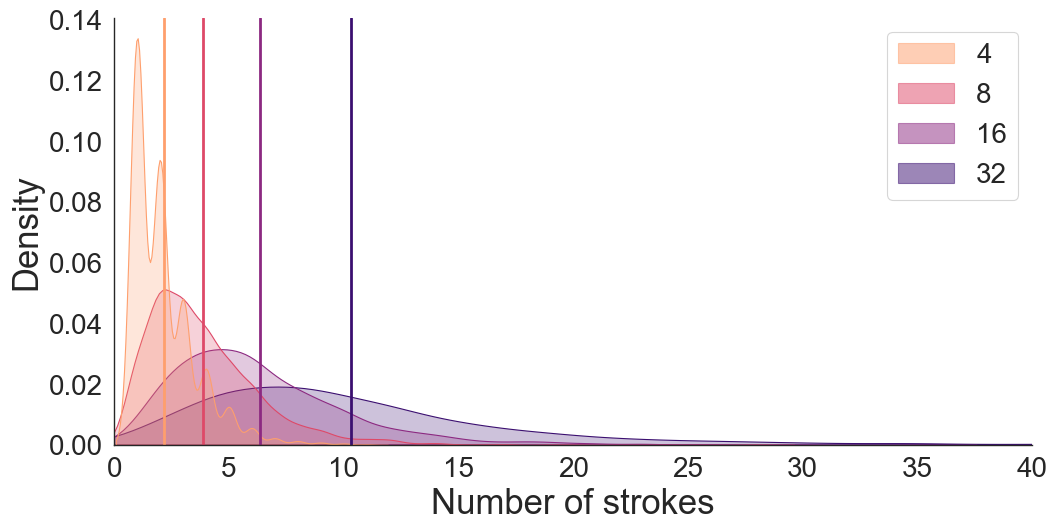

In [19]:

from matplotlib.patches import Patch
histcolors = sns.color_palette('magma_r', n_colors=len(human_response_vec_df['abstraction'].unique()))


### taking the dataframe above make a histogram of num_strokes grouped by abstraction, make it a density plot
sns.displot(data=human_response_vec_df, x='num_strokes', hue='abstraction', kind='kde',palette=histcolors, fill=True, legend=False,\
            height=5, aspect=2)

mean_num_strokes = human_response_vec_df.groupby('abstraction')['num_strokes'].mean()

# plot the vertical lines with the same colors as the density plot
for i, abs_level in enumerate(mean_num_strokes.index):
    plt.axvline(x=mean_num_strokes[abs_level], color=histcolors[i],linewidth=2)

## show legend with the color of the boxes matching the order in histcolors
plt.legend(handles=[Patch(color=histcolors[i], label=abs_level, alpha=.5) for i, abs_level in enumerate(mean_num_strokes.index)],fontsize=20)
plt.xlabel('Number of strokes', fontsize=25)
plt.ylabel('Density', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
### increase the size of the legend markers

plt.xlim(0,40)
# plt.title('Distribution of stroke complexity by abstraction level (Human sketches)', fontsize=20)
plt.savefig(os.path.join(plot_dir,'neuripsDB_stroke_complexity_by_dd.pdf'), dpi=300, bbox_inches='tight')
plt.show()


#### Sparser sketches are more semantically ambiguous for models and humans  +
#### Different models display distinct patterns of sketch recognition behavior.

In [20]:
tab20 = sns.color_palette("tab20", 20)

In [21]:
for this_model in model_list:
    if this_model.startswith('harm'): ##fix for harmonizimg models
        human_response_vec_df[f'H_{this_model}_late'] = human_response_vec_df[f'proba_{this_model.split("-")[0]}-{this_model.split("-")[1]}_late'].apply(lambda x: entropy(x))
    else:
        human_response_vec_df[f'H_{this_model}_late'] = human_response_vec_df[f'proba_{this_model}_late'].apply(lambda x: entropy(x))
for this_model in model_list:
    if this_model not in ['ipcl','harm-vit','harm-rn','cornet','ecoset','simclr']:
        machine_response_vec_df[f'H_{this_model}_late'] = machine_response_vec_df[f'proba_{this_model}_late'].apply(lambda x: entropy(x))


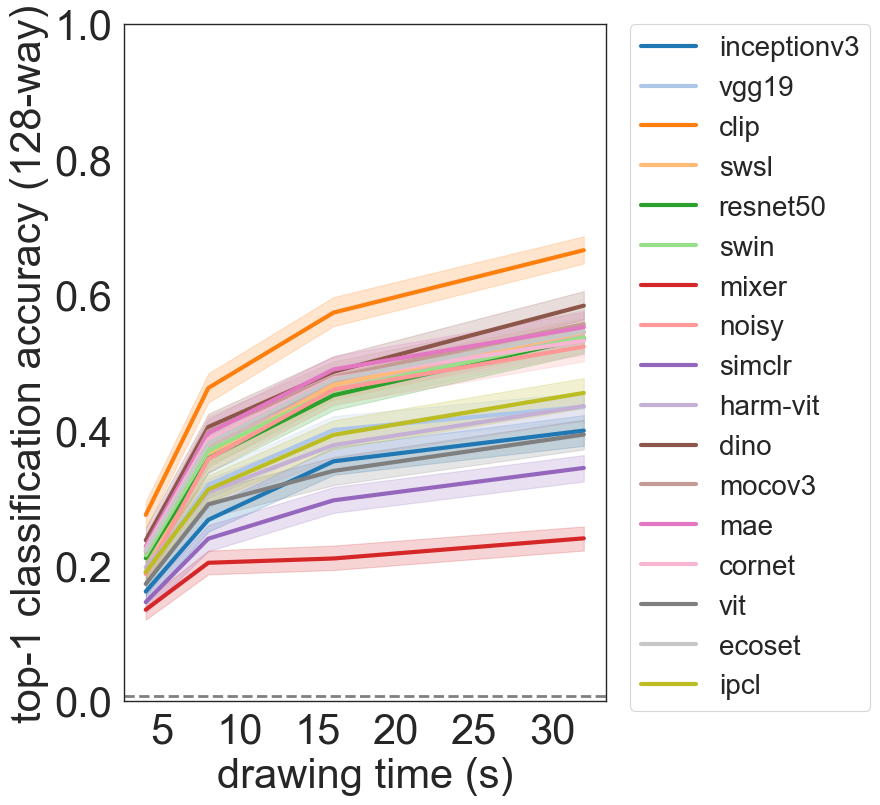

In [22]:


plt.figure(figsize=(9,8))

# sns.lineplot(data=human_response_vec_df, x='abstraction', y='mean_top1_accuracy',label='human',color=tab20[0],linewidth=3)
for i,model in enumerate(model_list):
    sns.lineplot(data=human_response_vec_df, x='abstraction', y=f'top1_{model}_late',label=model,color=tab20[i],linewidth=3)
plt.xlabel('drawing time (s)',fontsize=30)
plt.ylabel('top-1 classification accuracy (128-way)',fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
### increase the size of the legend text
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()
# plt.title('Human sketches',fontsize=25)
plt.ylim(0,1)
plt.axhline(y=(1/128), color='gray', linestyle='--',linewidth=2)
plt.savefig(os.path.join(plot_dir,'neuripsDB_accuracy_v_dd.pdf'), dpi=300, bbox_inches='tight')
### place the legend outside the figure/plot



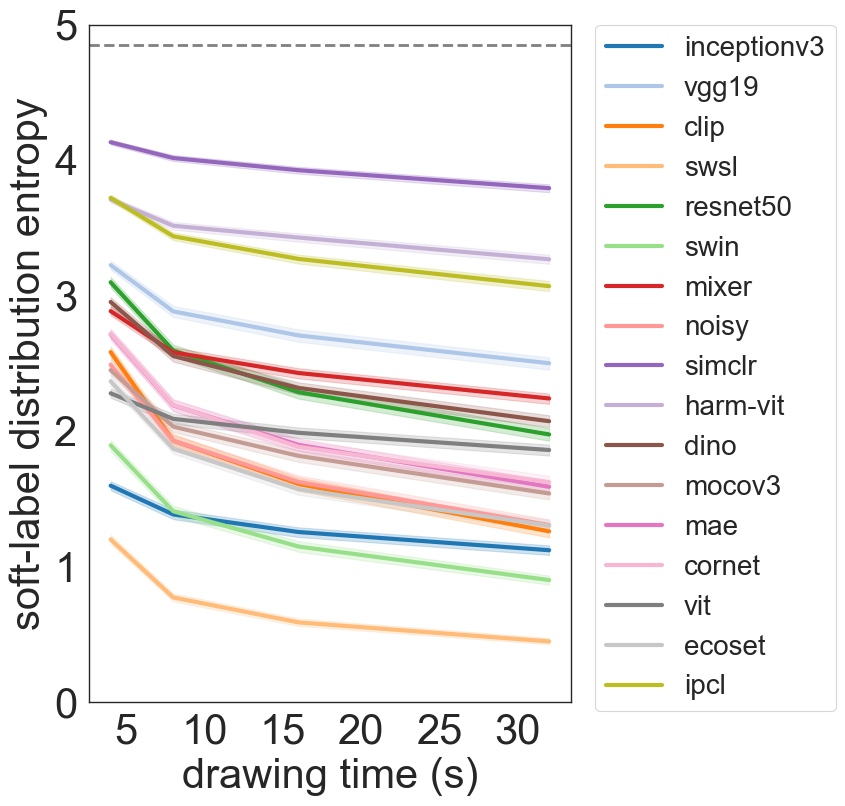

In [23]:


plt.figure(figsize=(9,8))

# sns.lineplot(data=human_response_vec_df, x='abstraction', y='mean_top1_accuracy',label='human',color=tab20[0],linewidth=3)
for i,model in enumerate(model_list):
    sns.lineplot(data=human_response_vec_df, x='abstraction', y=f'H_{model}_late',label=model,color=tab20[i],linewidth=3)
plt.xlabel('drawing time (s)',fontsize=30)
plt.ylabel('soft-label distribution entropy',fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
### increase the size of the legend text
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()
# plt.title('Human sketches',fontsize=25)
plt.ylim(0,5)
plt.axhline(y=entropy(np.ones(128)), color='gray', linestyle='--',linewidth=2)
plt.savefig(os.path.join(plot_dir,'neuripsDB_entropy_v_dd.pdf'), dpi=300, bbox_inches='tight')
### place the legend outside the figure/plot



In [24]:
human_response_vec_df.groupby('abstraction')['mean_top1_accuracy','entropy'].agg(['mean','sem'])

response_list mean_top1_accuracy             entropy          
                            mean       sem      mean       sem
abstraction                                                   
4                       0.030829  0.002693  1.958259  0.010626
8                       0.081503  0.004413  1.814551  0.012780
16                      0.138663  0.005864  1.689727  0.014093
32                      0.198681  0.006715  1.554702  0.014858

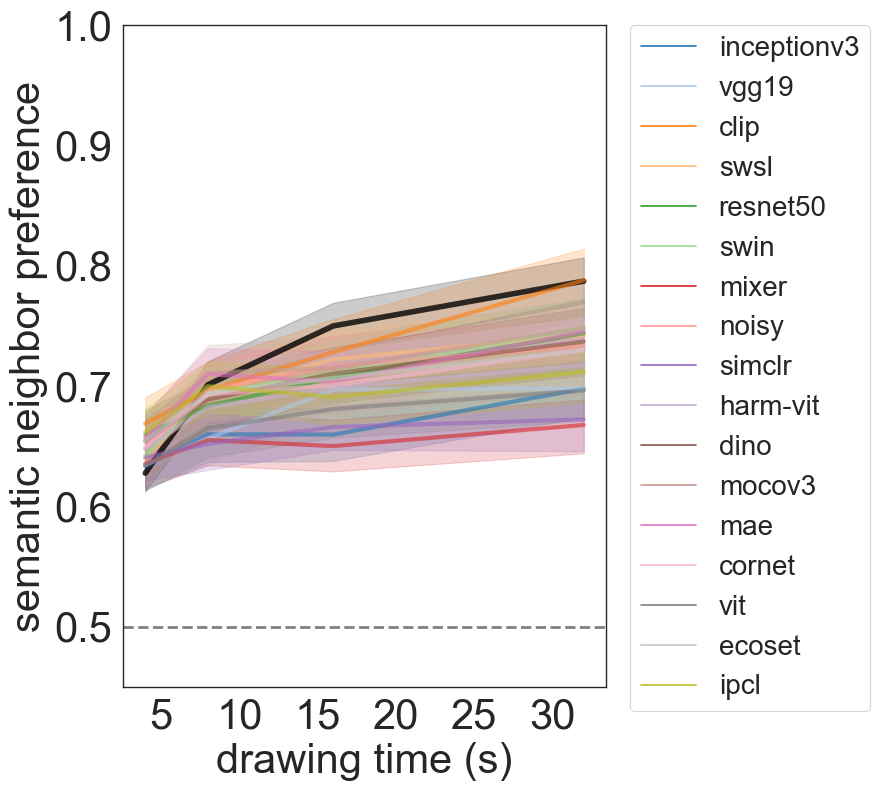

In [25]:


plt.figure(figsize=(9,8))
sns.lineplot(data=auc_df, x ='abstraction', y='auc',linewidth=4,alpha=.8,color='black')
plt.xlabel('drawing time (ms)',fontsize=25)
plt.ylabel('semantic neighbor preference',fontsize=25)




# plt.figure(figsize=(15,8))
sns.lineplot(data=model_auc_df, x ='abstraction', y='auc', hue='model',alpha=.6,palette=tab20,linewidth=3)
# sns.lineplot(data=human_response_vec_df, x='abstraction', y='mean_top1_accuracy',label='human',color=tab20[0],linewidth=3)
plt.ylim(.45,1)
plt.xlabel('drawing time (s)',fontsize=30)
plt.ylabel('semantic neighbor preference',fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

plt.axhline(y=.5, color='gray', linestyle='--',linewidth=2)
### increase the size of the legend text
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

plt.savefig(os.path.join(plot_dir,'neuripsDB_accuracy_v_snp.pdf'), dpi=300, bbox_inches='tight')
plt.show()



In [26]:
auc_df.groupby('abstraction')['auc'].agg(['mean','sem'])

,mean,sem
abstraction,,
4.0,0.627561,0.007923
8.0,0.701014,0.009194
16.0,0.749846,0.009994
32.0,0.787072,0.009865


#### A large gap remains between human and model sketch understanding.

In [27]:

model_acc_EVs_dict = {key: [] for key in model_list}
model_H_EVs_dict = {key: [] for key in model_list}
model_snp_EVs_dict = {key: [] for key in model_list}


for i in range(2):
    # Get unique conditions outside the loop
    unique_conditions = human_response_vec_df.abstraction.unique()

    # Create an empty list to collect filtered rows
    filtered_rows = []
    filtered_recog_rows = []

    for concept in human_response_vec_df.concept.unique():
        unique_ims = human_response_vec_df[human_response_vec_df.concept == concept].filename.unique()
        # Sample 16 items from unique_ims with replacement
        sample_ims = np.random.choice(unique_ims, 16, replace=True)
        this_sample = list(itertools.product(sample_ims, unique_conditions))

        for t in this_sample:
            # Filter rows using boolean indexing
            filtered_rows.append(human_response_vec_df[(human_response_vec_df.filename == t[0]) & (human_response_vec_df.abstraction == t[1])])
            filtered_recog_rows.append(human_recog_df[(human_recog_df.filename == t[0]) & (human_recog_df.abstraction == t[1])])

    # Concatenate all filtered rows once
    this_sample_df = pd.concat(filtered_rows)
    this_sample_recog_df = pd.concat(filtered_recog_rows)

    ## aggregate by condition and concept
    this_mean_df = this_sample_df.groupby(['concept','abstraction']).mean().reset_index()

    this_auc_df = compute_human_snp(this_sample_recog_df)
   
    for this_model in model_list:
        # acc_EVs=[]
        # H_EVs=[]
        # snp_EVs []
        if this_model in ['harm-vit','harm-rn']:
            this_mean_df= this_mean_df.rename(columns={f'top1_{this_model}_late':f'top1_{this_model.split("-")[0]}_{this_model.split("-")[1]}_late'})
            this_mean_df= this_mean_df.rename(columns={f'H_{this_model}_late':f'H_{this_model.split("-")[0]}_{this_model.split("-")[1]}_late'})
            m_acc = ols(f'mean_top1_accuracy~top1_{this_model.split("-")[0]}_{this_model.split("-")[1]}_late*abstraction',data=this_mean_df).fit()
            m_H = ols(f'entropy~H_{this_model.split("-")[0]}_{this_model.split("-")[1]}_late*abstraction',data=this_mean_df).fit()
        else:
            ### fit a linear regression model to predict human accuracy from model accuracy
            m_acc = ols(f'mean_top1_accuracy~top1_{this_model}_late*abstraction',data=this_mean_df).fit()
            m_H = ols(f'entropy~H_{this_model}_late*abstraction',data=this_mean_df).fit()
        # acc_EVs.append(m_acc.rsquared_adj)
        # H_EVs.append(m_H.rsquared_adj)
        model_acc_EVs_dict[this_model].append(m_acc.rsquared_adj)
        model_H_EVs_dict[this_model].append(m_H.rsquared_adj)
        model_snp_EVs_dict[this_model].append(compute_snp_EV(this_sample_df=this_sample_df, this_sample_recog_df=this_sample_recog_df,this_model=this_model,this_auc_df=this_auc_df))




In [28]:


sh_recog_EVs_human=[]
sh_entropy_EVs_human=[]
sh_snp_EVs_human=[]

all_subs = human_recog_df.subjectID.unique()
for i in range(2):
    random.shuffle(all_subs)
    subset1 = all_subs[:all_subs.shape[0]//2]
    subset2 = all_subs[all_subs.shape[0]//2:]

    ###accuracy

    subset1_df = human_recog_df[human_recog_df.subjectID.isin(subset1)].groupby(['filename','concept','abstraction']).mean().reset_index()
    subset2_df = human_recog_df[human_recog_df.subjectID.isin(subset2)].groupby(['filename','concept','abstraction']).mean().reset_index()
    
    s1 = subset1_df.groupby(['concept','abstraction'])['top1_correct'].mean().reset_index()
    s2 = subset2_df.groupby(['concept','abstraction'])['top1_correct'].mean().reset_index()
    
    Y = s1['top1_correct'].values
    X = np.column_stack([s2['top1_correct'].values,s2['abstraction'].values,s2['top1_correct'].values*s2['abstraction'].values])
    X = sm.add_constant(X)
    m_acc = sm.OLS(Y,X).fit()

    sh_recog_EVs_human.append(m_acc.rsquared_adj)

    ###entropy


    subset1_response_vec = human_recog_df[human_recog_df.subjectID.isin(subset1)].explode('response_list').groupby(['filename_recog','abstraction','sketch_id',\
                                                    'concept','uniqueID','num_strokes'])['response_list'].value_counts().unstack(fill_value=0).reset_index()
    non_label_concepts = np.setdiff1d( things1854concepts, subset1_response_vec.columns)
    for concept in non_label_concepts:
        subset1_response_vec[concept]=0


    subset2_response_vec = human_recog_df[human_recog_df.subjectID.isin(subset2)].explode('response_list').groupby(['filename_recog','abstraction','sketch_id',\
                                                    'concept','uniqueID','num_strokes'])['response_list'].value_counts().unstack(fill_value=0).reset_index()
    non_label_concepts = np.setdiff1d( things1854concepts, subset2_response_vec.columns)
    for concept in non_label_concepts:
        subset2_response_vec[concept]=0


    subset1_response_vec['entropy'] = subset1_response_vec[things1854concepts.tolist()].apply(lambda x: entropy(x), axis=1)
    subset2_response_vec['entropy'] = subset2_response_vec[things1854concepts.tolist()].apply(lambda x: entropy(x), axis=1)
    s1 = subset1_response_vec.groupby(['concept','abstraction'])['entropy'].mean().reset_index()
    s2 = subset2_response_vec.groupby(['concept','abstraction'])['entropy'].mean().reset_index()

    Y = s1['entropy'].values
    X = np.column_stack([s2['entropy'].values,s2['abstraction'].values,s2['entropy'].values*s2['abstraction'].values])
    X = sm.add_constant(X)

    m_H = sm.OLS(Y,X).fit()
   
    sh_entropy_EVs_human.append(m_H.rsquared_adj)

    ###snp

    subset1_recog_df = human_recog_df[human_recog_df.subjectID.isin(subset1)]
    subset2_recog_df = human_recog_df[human_recog_df.subjectID.isin(subset2)]

    s1_auc_df = compute_human_snp(subset1_recog_df)
    s2_auc_df = compute_human_snp(subset2_recog_df)

    Y = s1_auc_df['auc'].values
    X = np.column_stack([s2_auc_df['auc'].values,s2_auc_df['abstraction'].values,s2_auc_df['auc'].values*s2_auc_df['abstraction'].values])
    X = sm.add_constant(X)

    m_snp = sm.OLS(Y,X).fit()
   
    sh_snp_EVs_human.append(m_snp.rsquared_adj)


    


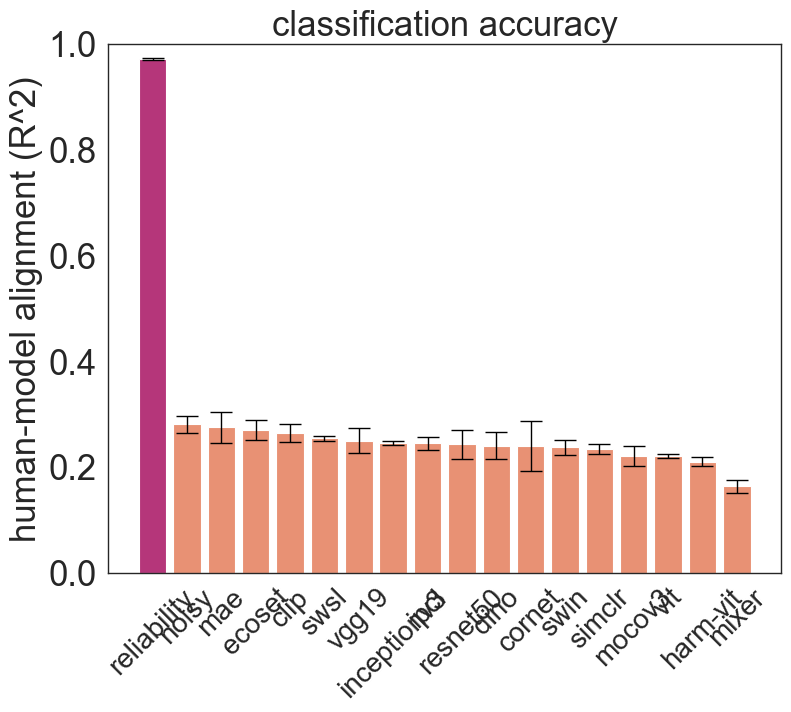

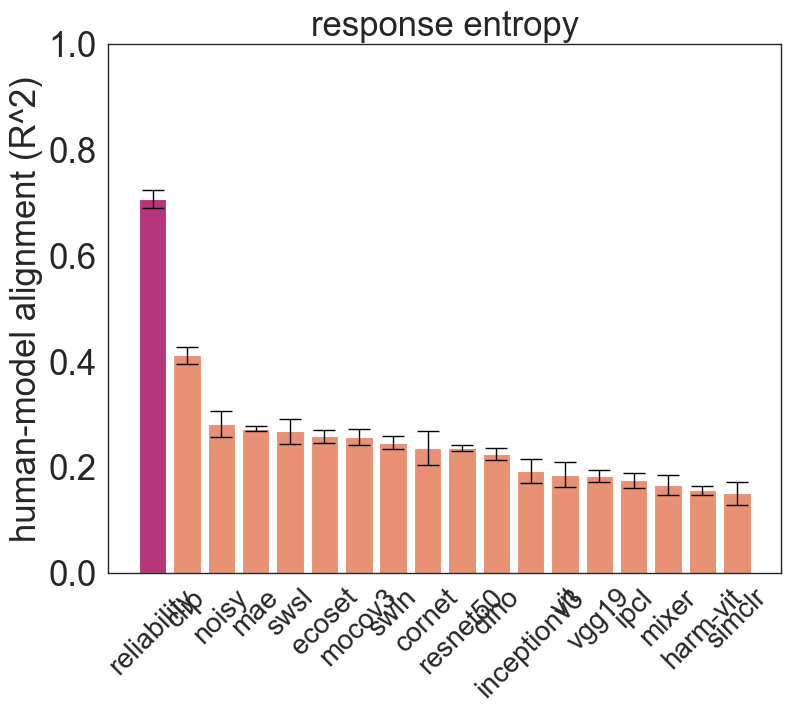

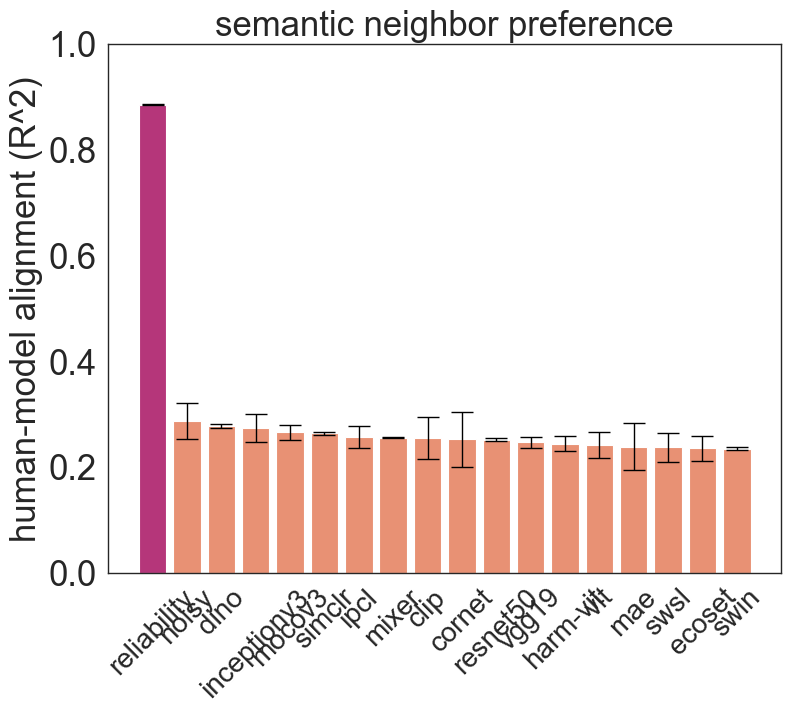

In [29]:
##load the magma_r colormap
bar_colors = sns.color_palette('magma_r', n_colors=3)

human_acc_EVs=[]
human_H_EVs=[]
human_snp_EVs = []
human_acc_EVs.append(np.mean(sh_recog_EVs_human))
human_H_EVs.append(np.mean(sh_entropy_EVs_human))
human_snp_EVs.append(np.mean(sh_snp_EVs_human))
for this_model in model_list:

    human_acc_EVs.append(np.mean(model_acc_EVs_dict[this_model]))
    human_H_EVs.append(np.mean(model_H_EVs_dict[this_model]))
    human_snp_EVs.append(np.mean(model_snp_EVs_dict[this_model]))




acc_df = pd.DataFrame({'model':np.insert(model_list, 0, 'reliability'),\
                       'EV':human_acc_EVs})
H_df = pd.DataFrame({'model':np.insert(model_list, 0, 'reliability'),\
                          'EV':human_H_EVs})
snp_df = pd.DataFrame({'model':np.insert(model_list, 0, 'reliability'),\
                            'EV':human_snp_EVs})


acc_df = acc_df.sort_values(by=['EV','model'],ascending=False)
H_df = H_df.sort_values(by=['EV','model'],ascending=False)
snp_df = snp_df.sort_values(by=['EV','model'],ascending=False)



tab20 = sns.color_palette('tab20',20)

plt.figure(figsize=(8,7))
# ax = sns.barplot(x='model',y='EV', data=acc_df, hue='agent',hue_order=['human','machine'], palette=[tab20[1],tab20[3]])
ax = sns.barplot(x='model',y='EV', data=acc_df, color=bar_colors[0])

bar_heights = [patch.get_height() for patch in ax.patches]

errors = []
errors.append(np.diff(np.percentile(sh_recog_EVs_human,[2.5,97.5])))
for this_model in model_list:
    errors.append(np.diff(np.percentile(model_acc_EVs_dict[this_model],[2.5,97.5]))[0])
# err0 = np.diff(np.percentile(sh_recog_EVs_human,[2.5,97.5]))

# Plot the error bars
ax.errorbar(ax.get_xticks(), bar_heights, yerr=errors,color='black',linewidth=1,capsize=8,fmt='none')
ax.patches[0].set_facecolor(bar_colors[1])
# ax.patches[13].set_facecolor(tab20[2])
plt.xlabel('',fontsize=25)
plt.ylabel('human-model alignment (R^2)',fontsize=25)
plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=25)
plt.ylim([0,1])
plt.tight_layout()
plt.title('classification accuracy',fontsize=25)
# plt.legend(fontsize=20)
plt.savefig(os.path.join(plot_dir,'neuripsDB_accuracy_alignment.pdf'), dpi=300, bbox_inches='tight')

plt.show()
#########


plt.figure(figsize=(8,7))
# ax = sns.barplot(x='model',y='EV', data=acc_df, hue='agent',hue_order=['human','machine'], palette=[tab20[1],tab20[3]])
ax = sns.barplot(x='model',y='EV', data=H_df, color=bar_colors[0])

bar_heights = [patch.get_height() for patch in ax.patches]

errors = []
errors.append(np.diff(np.percentile(sh_entropy_EVs_human,[2.5,97.5])))
for this_model in model_list:
    errors.append(np.diff(np.percentile(model_H_EVs_dict[this_model],[2.5,97.5]))[0])
# err0 = np.diff(np.percentile(sh_recog_EVs_human,[2.5,97.5]))

# Plot the error bars
ax.errorbar(ax.get_xticks(), bar_heights, yerr=errors,color='black',linewidth=1,capsize=8,fmt='none')
ax.patches[0].set_facecolor(bar_colors[1])
# ax.patches[13].set_facecolor(tab20[2])
plt.xlabel('',fontsize=25)
plt.ylabel('human-model alignment (R^2)',fontsize=25)
plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=25)
plt.ylim([0,1])
plt.tight_layout()
plt.title('response entropy',fontsize=25)
# plt.legend(fontsize=20)
plt.savefig(os.path.join(plot_dir,'neuripsDB_entropy_alignment.pdf'), dpi=300, bbox_inches='tight')

plt.show()


plt.figure(figsize=(8,7))
# ax = sns.barplot(x='model',y='EV', data=acc_df, hue='agent',hue_order=['human','machine'], palette=[tab20[1],tab20[3]])
ax = sns.barplot(x='model',y='EV', data=snp_df, color=bar_colors[0])

bar_heights = [patch.get_height() for patch in ax.patches]

errors = []
errors.append(np.diff(np.percentile(sh_snp_EVs_human,[2.5,97.5])))
for this_model in model_list:
    errors.append(np.diff(np.percentile(model_snp_EVs_dict[this_model],[2.5,97.5]))[0])
# err0 = np.diff(np.percentile(sh_recog_EVs_human,[2.5,97.5]))

# Plot the error bars
ax.errorbar(ax.get_xticks(), bar_heights, yerr=errors,color='black',linewidth=1,capsize=8,fmt='none')
ax.patches[0].set_facecolor(bar_colors[1])
# ax.patches[13].set_facecolor(tab20[2])
plt.xlabel('',fontsize=25)
plt.ylabel('human-model alignment (R^2)',fontsize=25)
plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=25)
plt.ylim([0,1])
plt.tight_layout()
plt.title('semantic neighbor preference',fontsize=25)

plt.savefig(os.path.join(plot_dir,'neuripsDB_snp_alignment.pdf'), dpi=300, bbox_inches='tight')

plt.show()

 

In [30]:
## t-tests

model_recog_EVs=[]
model_H_EVs =[]
model_snp_EVs = []
for model in model_list:
    model_recog_EVs.extend(model_acc_EVs_dict[this_model])
    model_H_EVs.extend(model_H_EVs_dict[this_model])
    model_snp_EVs.extend(model_snp_EVs_dict[this_model])


## do an independent samples t-test between model_recog_EVs and sh_recog_EVs_human

print('acc',ttest_ind(sh_recog_EVs_human,model_recog_EVs,equal_var=False))
print('H',ttest_ind(sh_entropy_EVs_human,model_H_EVs,equal_var=False))
print('snp',ttest_ind(sh_snp_EVs_human,model_snp_EVs,equal_var=False))




acc Ttest_indResult(statistic=431.333671642013, pvalue=1.270553108307834e-08)
H Ttest_indResult(statistic=61.23213234766212, pvalue=0.006850228356962677)
snp Ttest_indResult(statistic=1972.7143099073278, pvalue=2.904961136795266e-12)


In [31]:

acc_order = acc_df.reset_index().rename(columns={'index': 'model_index'}).sort_values(by='model_index').index.values[1:]
H_order = H_df.reset_index().rename(columns={'index': 'model_index'}).sort_values(by='model_index').index.values[1:]
snp_order = snp_df.reset_index().rename(columns={'index': 'model_index'}).sort_values(by='model_index').index.values[1:]

In [32]:

# Combine rank sets into a 2D array
rank_matrix = np.array([acc_order, H_order, snp_order])

# Compute Spearman's rank correlation matrix
correlation_matrix, p_values = spearmanr(rank_matrix, axis=1)

print("Spearman's Rank Correlation Matrix:")
print(correlation_matrix)


Spearman's Rank Correlation Matrix:
[[ 1.          0.70098039 -0.04411765]
 [ 0.70098039  1.         -0.15196078]
 [-0.04411765 -0.15196078  1.        ]]


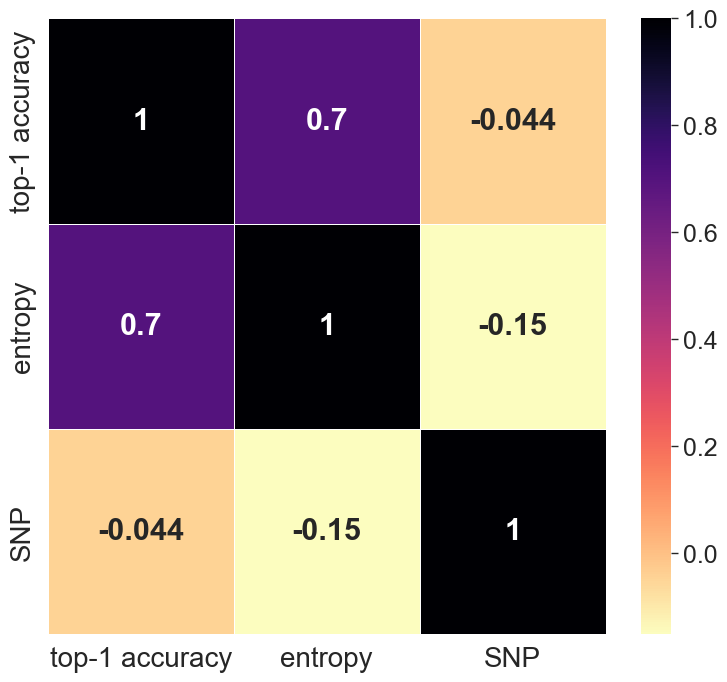

In [33]:
plt.figure(figsize=(9,8))
sns.heatmap(correlation_matrix, cmap='magma_r',annot=True,linewidth=.5,annot_kws={"size": 22,"fontweight":'bold'},xticklabels=['top-1 accuracy','entropy','SNP'],yticklabels=['top-1 accuracy','entropy','SNP'])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
cbar = plt.gcf().axes[-1]
cbar.tick_params(labelsize=18)
plt.savefig(os.path.join(plot_dir,'neuripsDB_metrics_spearmanr.pdf'), dpi=300, bbox_inches='tight')
plt.show()

In [35]:


###create output dataframe for human sketches for R

human_sketches_R_df = human_response_vec_df[['sketch_id','abstraction','concept','num_strokes','entropy','mean_top1_accuracy']]
human_sketches_R_df['model']='human'
for this_model in model_list:
    tdf = human_response_vec_df[['sketch_id','abstraction','concept','num_strokes', f'H_{this_model}_late', f'top1_{this_model}_late']]
    tdf.columns = ['sketch_id','abstraction','concept','num_strokes', 'entropy', 'mean_top1_accuracy']
    tdf['model']=this_model
    human_sketches_R_df = pd.concat([human_sketches_R_df,tdf]).reset_index(drop=True)
    

human_sketches_R_df.to_csv(os.path.join(data_dir,'human_sketches_R_df.csv'),index=False)


auc_df['model']='human'
snp_R_df = pd.concat([auc_df,model_auc_df]).reset_index(drop=True)
snp_R_df.to_csv(os.path.join(data_dir,'snp_R_df.csv'),index=False)

## CLIPasso analyses

#### A CLIP-based sketch generation algorithm emulates human sketches under some conditions

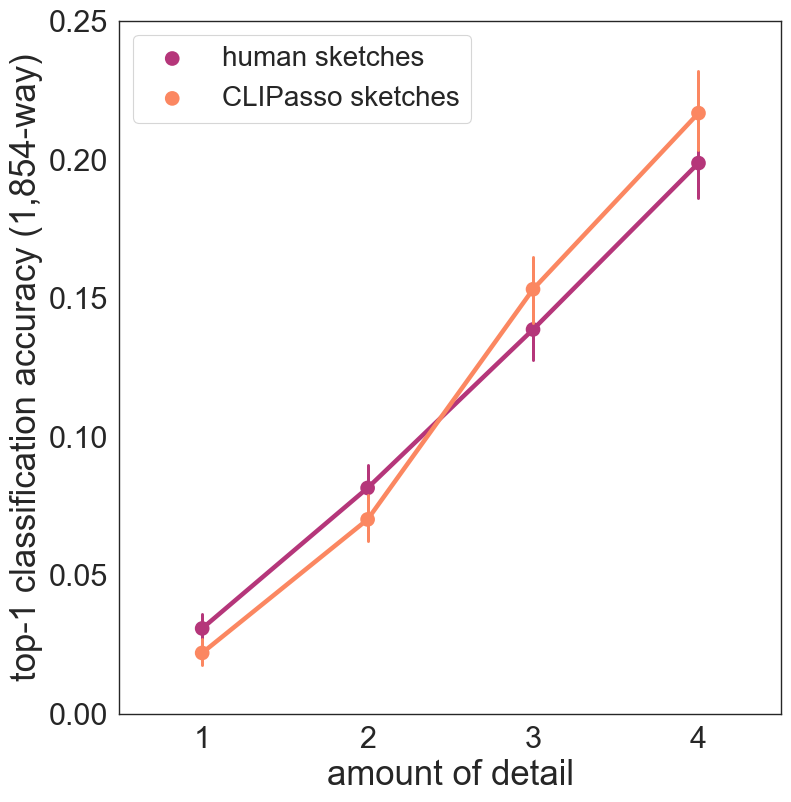

In [36]:
# human_response_vec_df.abstraction = human_response_vec_df.abstraction.astype(int)/1000
plt.figure(figsize=(8,8))
sns.pointplot(data=human_response_vec_df, x='abstraction', y='mean_top1_accuracy',label='human sketches',color=bar_colors[1],scale=1.5)
sns.pointplot(data=machine_response_vec_df, x='abstraction', y='mean_top1_accuracy',label='CLIPasso sketches',color=bar_colors[0],scale=1.5)
plt.xlabel('amount of detail',fontsize=25)
plt.ylabel('top-1 classification accuracy (1,854-way)',fontsize=25)


plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
## change the x tick labels to be ['1','2','3','4']
plt.gca().set_xticklabels(['1','2','3','4'])
plt.legend(fontsize=20)
plt.tight_layout()
plt.ylim(0,.25)
plt.savefig(os.path.join(plot_dir,'neuripsDB_human_CLIPasso_accuracy.pdf'), dpi=300, bbox_inches='tight')
plt.show()

CLIPasso-human recognition accuracy vs. human-human recognition accuracy 

In [37]:
pearsonr(human_response_vec_df[~((human_response_vec_df.filename=='canvas_09s.jpg')&(human_response_vec_df.abstraction==32))].sort_values(['concept','abstraction'])['mean_top1_accuracy'],\
            machine_response_vec_df.sort_values(['concept','abstraction'])['mean_top1_accuracy'])

PearsonRResult(statistic=0.5095041010937416, pvalue=0.0)

In [38]:


human_machine_recog_df =pd.DataFrame(
    {
        "human": human_response_vec_df[~((human_response_vec_df.filename=='canvas_09s.jpg')&(human_response_vec_df.abstraction==32))].sort_values(['concept','abstraction'])['mean_top1_accuracy'].values,
        "machine": machine_response_vec_df.sort_values(['concept','abstraction'])['mean_top1_accuracy'].values,
        "abstraction": human_response_vec_df[~((human_response_vec_df.filename=='canvas_09s.jpg')&(human_response_vec_df.abstraction==32))].sort_values(['concept','abstraction'])['abstraction'].values,
        "concept": human_response_vec_df[~((human_response_vec_df.filename=='canvas_09s.jpg')&(human_response_vec_df.abstraction==32))].sort_values(['concept','abstraction'])['concept'].values,

    }
)

In [39]:

agg_human_machine_recog_df = human_machine_recog_df.groupby(['concept','abstraction']).mean().reset_index()
md= smf.ols('human~machine*abstraction',data=agg_human_machine_recog_df).fit()
print(md.summary())

                            OLS Regression Results                            
Dep. Variable:                  human   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     306.7
Date:                Tue, 13 Jun 2023   Prob (F-statistic):          1.38e-113
Time:                        21:36:28   Log-Likelihood:                 401.36
No. Observations:                 512   AIC:                            -794.7
Df Residuals:                     508   BIC:                            -777.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0213    

In [40]:



human_grouped_responses = human_response_vec_df.groupby(['concept','abstraction'])[things1854concepts].mean().reset_index()
machine_grouped_responses = machine_response_vec_df.groupby(['concept','abstraction'])[things1854concepts].mean().reset_index()
response_concepts = np.repeat(human_grouped_responses.concept.unique(),4)
concepts = []
conds = []
ranks = []

for this_cond in  human_grouped_responses.abstraction.unique():
    for this_concept in  human_grouped_responses.concept.unique():
        this_machine_responses = machine_grouped_responses[(machine_grouped_responses.concept==this_concept)\
                                                           &(machine_grouped_responses.abstraction== this_cond)][things1854concepts].values
        response_jsds = human_grouped_responses[things1854concepts].apply(lambda x: jsd(x, this_machine_responses[0]),axis=1)
        jsd_ranks = rankdata(response_jsds.values)
        this_concept_inds = [i for i, x in enumerate(response_concepts) if x == this_concept]
        this_min_rank = np.min(jsd_ranks[this_concept_inds])
        concepts.append(this_concept)
        conds.append(this_cond)
        ranks.append(this_min_rank)

rank_df = pd.DataFrame({'concept': concepts, 'abstraction': conds, 'rank': ranks})


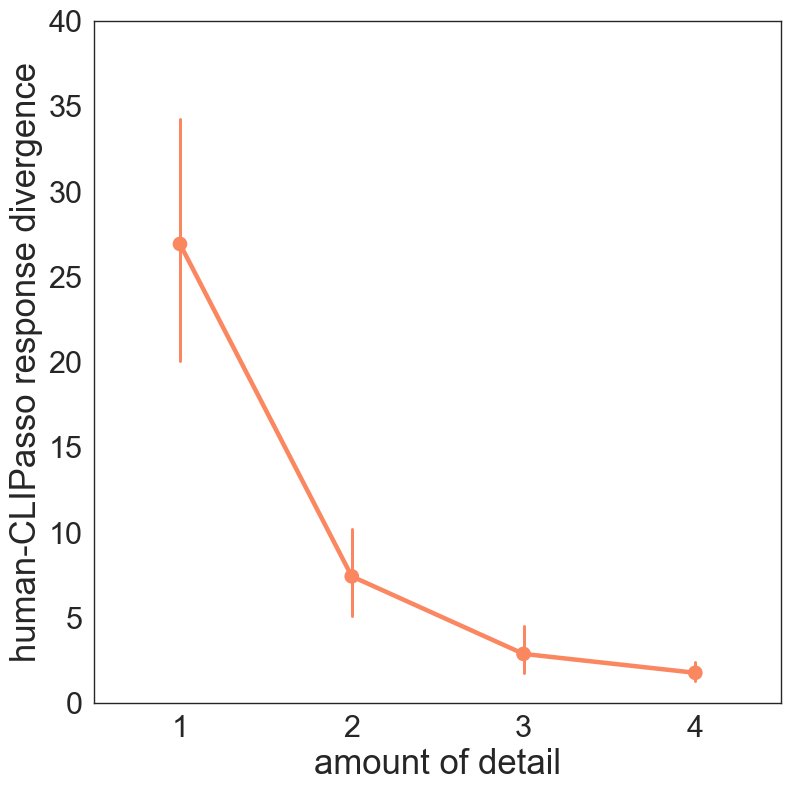

In [41]:
plt.figure(figsize=(8,8))
sns.pointplot(data=rank_df, x='abstraction', y='rank',color=bar_colors[0],scale=1.5)
plt.xlabel('amount of detail',fontsize=25)
plt.ylabel('human-CLIPasso response divergence',fontsize=25)
plt.gca().set_xticklabels(['1','2','3','4'])
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.ylim(0,40)
plt.savefig(os.path.join(plot_dir,'neuripsDB_human_CLIPasso_divergence.pdf'), dpi=300, bbox_inches='tight')
plt.tight_layout()

In [42]:

##make rank_df['abstraction'] into a categorical variable
# rank_df['abstraction'] = rank_df['abstraction'].astype('category')
md= smf.ols('rank~abstraction',data=rank_df).fit()
print(md.summary())

                            OLS Regression Results                            
Dep. Variable:                   rank   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     47.07
Date:                Tue, 13 Jun 2023   Prob (F-statistic):           2.00e-11
Time:                        21:36:40   Log-Likelihood:                -2357.5
No. Observations:                 512   AIC:                             4719.
Df Residuals:                     510   BIC:                             4728.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      20.0197      1.841     10.873      